In [4]:
import pandas as pd
import matplotlib.pyplot as plt

def draw(CHECKPOINT, DISTANCE, GPT_TEMP):
    # Overall title
    if CHECKPOINT == "X":
        TITLE = "CoV-RoBERTa without Contrastive Learning"
    elif CHECKPOINT == "4":
        TITLE = "CoV-SNN Transformer with Best Zero-shot Accuracy"
    elif CHECKPOINT == "0":
        TITLE = "CoV-SNN Transformer with Best Test Accuracy"

    # Reading the data
    df_eris_cscs = pd.read_csv(f"outputs/cscs_CP{CHECKPOINT}_{DISTANCE}/cscs_values_eris.csv")
    df_eris_cscs['cscs_sp'] = df_eris_cscs['log10(semantic_change)'] + df_eris_cscs['log10(grammaticality)']
    df_eris_cscs['cscs_ip'] = df_eris_cscs['log10(semantic_change)'] + df_eris_cscs['log10(1/perplexity)']

    df_new_cscs = pd.read_csv(f"outputs/cscs_CP{CHECKPOINT}_{DISTANCE}/cscs_values_new.csv")
    df_new_cscs['cscs_sp'] = df_new_cscs['log10(semantic_change)'] + df_new_cscs['log10(grammaticality)']
    df_new_cscs['cscs_ip'] = df_new_cscs['log10(semantic_change)'] + df_new_cscs['log10(1/perplexity)']

    df_gpt_cscs = pd.read_csv(f"outputs/cscs_CP{CHECKPOINT}_{DISTANCE}/cscs_values_GPT_{GPT_TEMP}.csv")
    df_gpt_cscs['cscs_sp'] = df_gpt_cscs['log10(semantic_change)'] + df_gpt_cscs['log10(grammaticality)']
    df_gpt_cscs['cscs_ip'] = df_gpt_cscs['log10(semantic_change)'] + df_gpt_cscs['log10(1/perplexity)']

    # Combine the three DataFrames into one for easier plotting
    df_combined = pd.concat([
        df_eris_cscs[['log10(grammaticality)', 'log10(semantic_change)', 'log10(1/perplexity)', 'cscs_sp', 'cscs_ip']].assign(source='Eris'),
        df_new_cscs[['log10(grammaticality)', 'log10(semantic_change)', 'log10(1/perplexity)', 'cscs_sp', 'cscs_ip']].assign(source='New'),
        df_gpt_cscs[['log10(grammaticality)', 'log10(semantic_change)', 'log10(1/perplexity)', 'cscs_sp', 'cscs_ip']].assign(source=f"GPT {GPT_TEMP}"),
    ])

    # print mean CSCS_SP and CSCS_IP for GPT
    print(f"GPT {GPT_TEMP} CSCS_SP: {df_gpt_cscs['cscs_sp'].mean()}")
    print(f"GPT {GPT_TEMP} CSCS_IP: {df_gpt_cscs['cscs_ip'].mean()}")


    # Plotting the boxplots
    plt.figure(figsize=(10, 5))

    # Plot boxplots for CSCS
    ax4 = plt.subplot(1, 2, 1)
    df_combined.boxplot(column='cscs_sp', by='source', ax=ax4)
    plt.title('CSCS based on SP (log$_{10}$)')
    plt.suptitle('')
    plt.xlabel('')
    plt.ylabel('')

    # Plot boxplots for CSCS
    ax5 = plt.subplot(1, 2, 2)
    df_combined.boxplot(column='cscs_sp', by='source', ax=ax5)
    plt.title('CSCS based on IP (log$_{10}$)')
    plt.suptitle(f'{TITLE}')
    plt.xlabel('')
    plt.ylabel('')

    # Font size settings
    font_size = 16
    plt.rc('font', size=font_size)
    plt.rc('axes', titlesize=font_size)
    plt.rc('axes', labelsize=font_size)
    plt.rc('xtick', labelsize=font_size)
    plt.rc('ytick', labelsize=font_size)
    plt.rc('legend', fontsize=font_size)
    plt.rc('figure', titlesize=font_size)

    plt.tight_layout(rect=[0, 0.03, 1, 1.03])
    fig_file_name = f"figures/cscs_box_CP{CHECKPOINT}_{DISTANCE}_{GPT_TEMP}.pdf"
    plt.savefig(fig_file_name)
    plt.show()


GPT 1.0 CSCS_SP: -2.126288248798196
GPT 1.0 CSCS_IP: -2.169810003116949


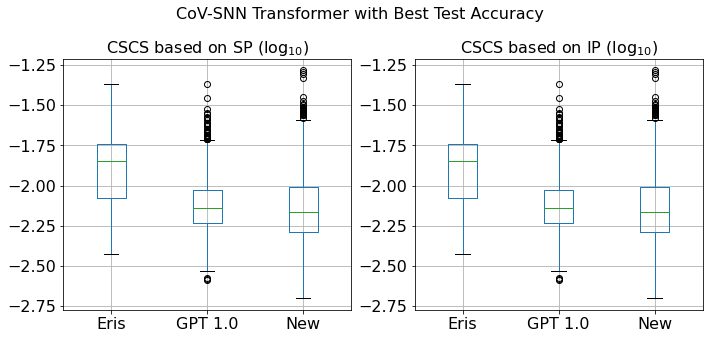

GPT 1.1 CSCS_SP: -2.095481457053919
GPT 1.1 CSCS_IP: -2.1493341419453755


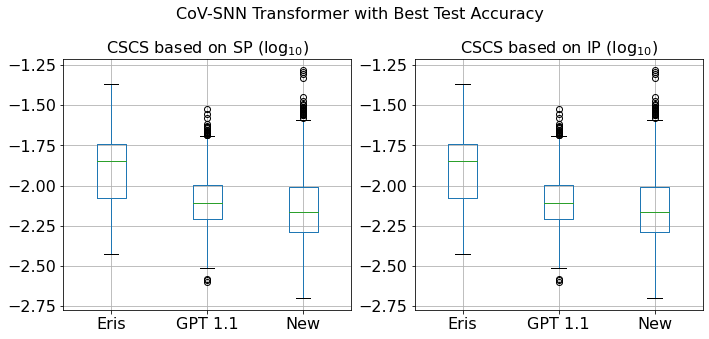

GPT 1.2 CSCS_SP: -2.0408797256260067
GPT 1.2 CSCS_IP: -2.106492195662353


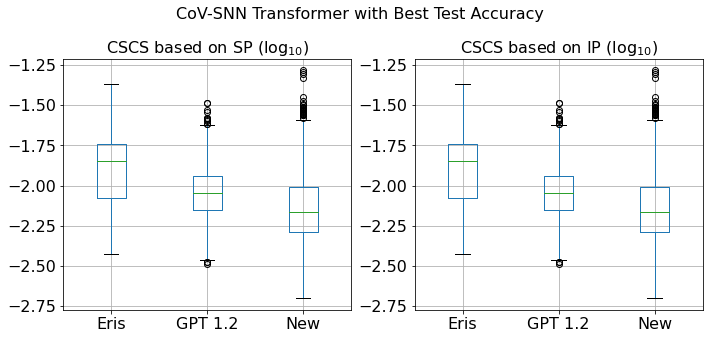

GPT 1.5 CSCS_SP: -1.8287157200248183
GPT 1.5 CSCS_IP: -1.9077419628018069


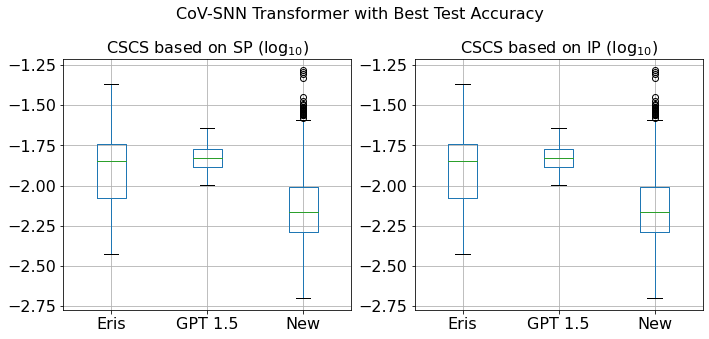

In [37]:
draw(CHECKPOINT="0", DISTANCE="L2", GPT_TEMP="1.0")
draw(CHECKPOINT="0", DISTANCE="L2", GPT_TEMP="1.1")
draw(CHECKPOINT="0", DISTANCE="L2", GPT_TEMP="1.2")
draw(CHECKPOINT="0", DISTANCE="L2", GPT_TEMP="1.5")

GPT 1.0 CSCS_SP: -3.41206559200894
GPT 1.0 CSCS_IP: -3.532313012503866


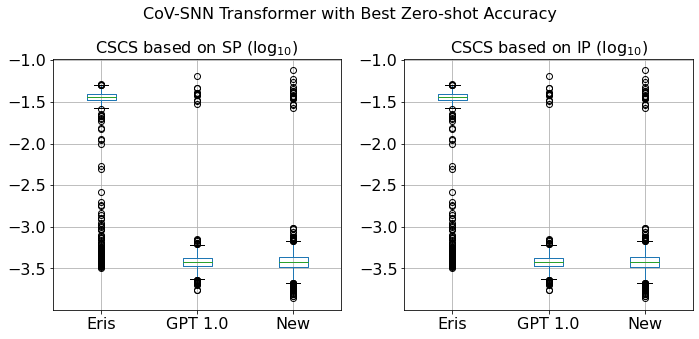

GPT 1.1 CSCS_SP: -3.3560884902399155
GPT 1.1 CSCS_IP: -3.4474554516929095


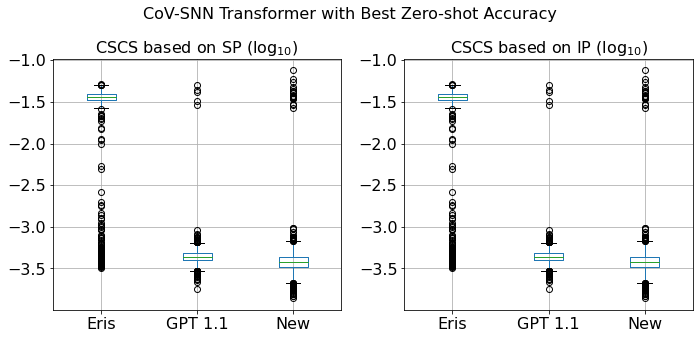

GPT 1.2 CSCS_SP: -3.3539666882056225
GPT 1.2 CSCS_IP: -3.439121515559736


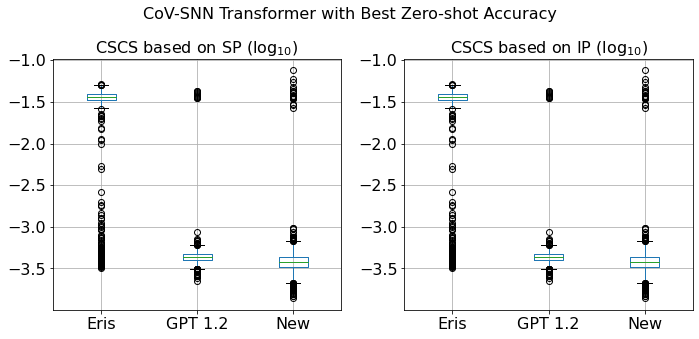

GPT 1.5 CSCS_SP: -3.359643015903996
GPT 1.5 CSCS_IP: -3.431105206397034


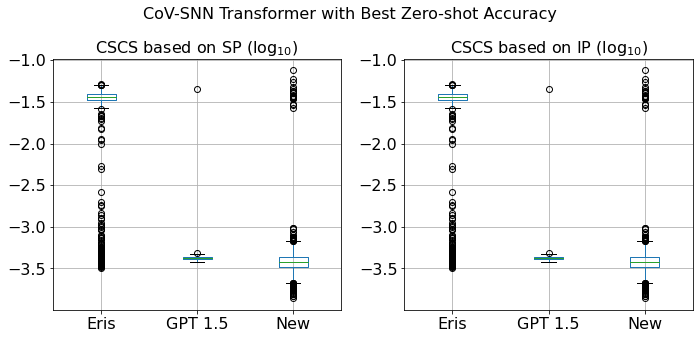

In [38]:
draw(CHECKPOINT="4", DISTANCE="L2", GPT_TEMP="1.0")
draw(CHECKPOINT="4", DISTANCE="L2", GPT_TEMP="1.1")
draw(CHECKPOINT="4", DISTANCE="L2", GPT_TEMP="1.2")
draw(CHECKPOINT="4", DISTANCE="L2", GPT_TEMP="1.5")

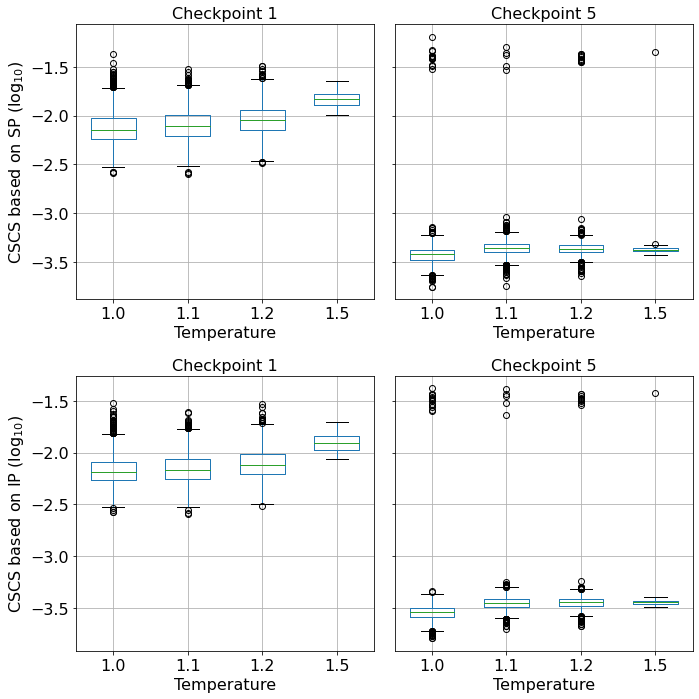

In [36]:
import pandas as pd
import matplotlib.pyplot as plt

def draw_only_gpt():
    DISTANCE = "L2"
    CHECKPOINTS = ["0", "4"]
    TEMPS = ["1.0", "1.1", "1.2", "1.5"]

    # Font size settings
    font_size = 16
    plt.rc('font', size=font_size)
    plt.rc('axes', titlesize=font_size)
    plt.rc('axes', labelsize=font_size)
    plt.rc('xtick', labelsize=font_size)
    plt.rc('ytick', labelsize=font_size)
    plt.rc('legend', fontsize=font_size)
    plt.rc('figure', titlesize=font_size)

    fig, axes = plt.subplots(2, len(CHECKPOINTS), figsize=(10, 10), sharey='row')

    for i, CHECKPOINT in enumerate(CHECKPOINTS):
        dfs = {}

        for TEMP in TEMPS:
            # Reading the data
            df = pd.read_csv(f"outputs/cscs_CP{CHECKPOINT}_{DISTANCE}/cscs_values_GPT_{TEMP}.csv")
            df['cscs_sp'] = df['log10(semantic_change)'] + df['log10(grammaticality)']
            df['cscs_ip'] = df['log10(semantic_change)'] + df['log10(1/perplexity)']
            
            # Store the dataframe
            dfs[TEMP] = df
        
        # Plotting the boxplots for cscs_sp (first row)
        for j, TEMP in enumerate(TEMPS):
            dfs[TEMP].boxplot(column='cscs_sp', ax=axes[0, i], positions=[j+1], widths=0.6)
        
        # Plotting the boxplots for cscs_ip (second row)
        for j, TEMP in enumerate(TEMPS):
            dfs[TEMP].boxplot(column='cscs_ip', ax=axes[1, i], positions=[j+1], widths=0.6)
        
        # Set titles and labels
        axes[0, i].set_title(f'Checkpoint {int(CHECKPOINT) + 1}')
        axes[0, i].set_xticklabels([f'{TEMP}' for TEMP in TEMPS])
        axes[0, i].set_xlabel('Temperature')

        axes[1, i].set_title(f'Checkpoint {int(CHECKPOINT) + 1}')
        axes[1, i].set_xticklabels([f'{TEMP}' for TEMP in TEMPS])
        axes[1, i].set_xlabel('Temperature')


    axes[0, 0].set_ylabel('CSCS based on SP (log$_{10}$)')
    axes[1, 0].set_ylabel('CSCS based on IP (log$_{10}$)')
    
    plt.tight_layout(rect=[0, 0.03, 1, 1.03])
    plt.show()

draw_only_gpt()
